# Likelihood calculée sur toutes les interactions avec le système

In [1]:
import sys

sys.path.append("/Users/olivier/PycharmProjects/bayesian-kst/")  # for ubuntu
from kgraph.expert_layer.domain_graph import DomainGraph
from kgraph.expert_layer.knowledge_components import KnowledgeComponent, ProceduralKnowledgeComponent
from kgraph.expert_layer.links import LinkModel, LinkFromParents, LinkFromChildren
from kgraph.resources_layer.exercise_family import ExerciseFamily
from kgraph.resources_layer.exercise import Exercise
from kgraph.learner_layer.evaluation import Evaluation
from kgraph.learner_layer.learner_pool import LearnerPool
from kgraph.learner_layer.learner import Learner, LearnerGraph
from kgraph.helpers.truthtable import truthtable
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

## Modélisation du réseau bayésien dynamique à partir du modèle du domaine

In [2]:
def get_two_dbn(domain_graph):
    knowledge_components = domain_graph.get_knowledge_components()
    twodbn = gum.BayesNet()
    
    for kc in knowledge_components:
        twodbn.add(gum.LabelizedVariable(f"{kc.name}0",f"{kc.name}0",2))
        twodbn.add(gum.LabelizedVariable(f"{kc.name}t",f"{kc.name}t",2))
        twodbn.add(gum.LabelizedVariable(f"eval{kc.name}t",f"eval{kc.name}t",2))
        twodbn.addArc(f"{kc.name}0",f"{kc.name}t")
        twodbn.addArc(f"{kc.name}t",f"eval{kc.name}t")
    for kc in knowledge_components:
        for parent in domain_graph.get_kc_parents(kc):
            twodbn.addArc(f"{parent.name}t",f"{kc.name}t")
    return twodbn
        
        
def get_parametered_twodbn(twodbn, stereotypes):
    
    twodbn.cpt("evalAt")[{'At': 0}] = [.75, .25]
    twodbn.cpt("evalAt")[{'At': 1}] = [.1, .9]
    twodbn.cpt("evalBt")[{'Bt': 0}] = [.75, .25]
    twodbn.cpt("evalBt")[{'Bt': 1}] = [.1, .9]

    if stereotypes['learner_profile'] == 'fast':
        twodbn.cpt("A0").fillWith([.7,.3])
        twodbn.cpt("B0").fillWith([.7,.3])
        twodbn.cpt("At")[{'A0': 0}] = [.7, .3]
        twodbn.cpt("At")[{'A0': 1}] = [.01, .99]
    elif stereotypes['learner_profile'] == 'average':
        twodbn.cpt("A0").fillWith([.8,.2])
        twodbn.cpt("B0").fillWith([.8,.2])
        twodbn.cpt("At")[{'A0': 0}] = [.8, .2]
        twodbn.cpt("At")[{'A0': 1}] = [.01, .99]
    elif stereotypes['learner_profile'] == 'slow':
        twodbn.cpt("A0").fillWith([.9,.1])
        twodbn.cpt("B0").fillWith([.9,.1])
        twodbn.cpt("At")[{'A0': 0}] = [.9, .1]
        twodbn.cpt("At")[{'A0': 1}] = [.01, .99]

    
    if stereotypes['link_a_to_b'] == 'strong':
        twodbn.cpt("Bt")[{'B0': 0, 'At': 0}] = [.99, .01]
        twodbn.cpt("Bt")[{'B0': 0, 'At': 1}] = [0.6, 0.4]
        twodbn.cpt("Bt")[{'B0': 1, 'At': 0}] = [0.7, 0.3]
        twodbn.cpt("Bt")[{'B0': 1, 'At': 1}] = [.01, .99]
    elif stereotypes['link_a_to_b'] == 'weak':
        twodbn.cpt("Bt")[{'B0': 0, 'At': 0}] = [.99, .01]
        twodbn.cpt("Bt")[{'B0': 0, 'At': 1}] = [0.8, 0.2]
        twodbn.cpt("Bt")[{'B0': 1, 'At': 0}] = [0.3, 0.7]
        twodbn.cpt("Bt")[{'B0': 1, 'At': 1}] = [.01, .99]
    elif stereotypes['link_a_to_b'] == 'not_existing':
        twodbn.cpt("Bt")[{'B0': 0, 'At': 0}] = [.99, .01]
        twodbn.cpt("Bt")[{'B0': 0, 'At': 1}] = [0.8, 0.2]
        twodbn.cpt("Bt")[{'B0': 1, 'At': 0}] = [.01, .99]
        twodbn.cpt("Bt")[{'B0': 1, 'At': 1}] = [.01, .99]
    
    return twodbn
        
    

In [3]:
# we define the KCs
KC_A = ProceduralKnowledgeComponent(1, "A")
KC_B = ProceduralKnowledgeComponent(2, "B")

# we define the link between the two that gonna lead to the link model
link_a_to_b = LinkFromParents(KC_B, [KC_A], [.4, .6])
link_b_to_a = LinkFromChildren(KC_A, [KC_B], [.1, .9])
link_model = LinkModel([link_a_to_b, link_b_to_a])

domain_graph = DomainGraph([KC_A, KC_B], link_model)

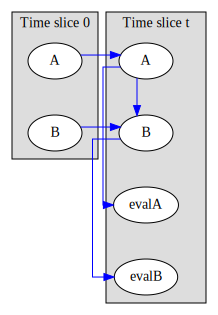

In [4]:
twodbn = get_two_dbn(domain_graph)
gdyn.showTimeSlices(twodbn)

## Modélisation de l'apprentissage de l'apprenant à partir d'ajout de preuves au modèle du domaine

In [5]:
# default params
params = {"slip": .1, "guess":.25}

# we define the exercises that corresponds to KC_A
ex_A_1 = Exercise(1, "qcm", ex_content="", params=params)
ex_A_2 = Exercise(2, "qcm", ex_content="", params=params)
ex_A_3 = Exercise(3, "qcm", ex_content="", params=params)
ex_A_4 = Exercise(4, "qcm", ex_content="", params=params)
ex_A_5 = Exercise(5, "qcm", ex_content="", params=params)

ex_fam_A = ExerciseFamily(1, "ex_fam_A", KC_A, [ex_A_1, ex_A_2, ex_A_3, ex_A_4, ex_A_5])

# we define the exercises that corresponds to KC_A
ex_B_1 = Exercise(6, "qcm", ex_content="", params=params)
ex_B_2 = Exercise(7, "qcm", ex_content="", params=params)
ex_B_3 = Exercise(8, "qcm", ex_content="", params=params)
ex_B_4 = Exercise(9, "qcm", ex_content="", params=params)
ex_B_5 = Exercise(10, "qcm", ex_content="", params=params)

ex_fam_B = ExerciseFamily(1, "ex_fam_B", KC_B, [ex_B_1, ex_B_2, ex_B_3, ex_B_4, ex_B_5])


learner_pool = LearnerPool(domain_graph)
learner_pool.setup_random_learners(1000)
n_evals = 3000
sim_evaluations = learner_pool.simulate_evaluations_from_learners(n_evals)
temp_eval = []
for i in range(len(sim_evaluations)):
    temp = []
    for evaluation in sim_evaluations[i]:
        temp += [(evaluation.get_kc(), int(evaluation.answers[key]["success"])) for key in list(evaluation.answers.keys())]
    temp_eval.append(temp)
sim_evaluations=temp_eval

In [6]:
def get_learner_dbn(twodbn, learner_evals):
    slip=.1
    guess=.25
    evidences = {}
    for i in range(len(learner_evals)):
        print(f"Evaluation #{i} on KC {learner_evals[i][0].name}: {'success' if learner_evals[i][1] else 'fail'}")
        # declaring hard evidences 
        evidences[f"eval{learner_evals[i][0].name}{i+1}"] = int(learner_evals[i][1]) 
        # declaring soft evidences
        #evidences[f"{learner_evals[i][0].name}{i+1}"] = [guess, 1-guess] if learner_evals[i][1] else [1-slip, slip]

    gdyn.plotFollow(["A","B"],twodbn,T=len(learner_evals)+1,evs={})
    
    return gdyn.unroll2TBN(twodbn,len(learner_evals)+1)


def get_learner_dbn_w_evidences(twodbn, learner_evals, evidence_type='soft'):
    slip=.1
    guess=.25
    print(evidence_type)
    evidences = {}
    for i in range(len(learner_evals)):
        print(f"Evaluation #{i} on KC {learner_evals[i][0].name}: {'success' if learner_evals[i][1] else 'fail'}")
        # declaring hard evidences 
        if evidence_type == 'hard':
            evidences[f"eval{learner_evals[i][0].name}{i+1}"] = int(learner_evals[i][1]) 
        elif evidence_type == 'soft':
            evidences[f"{learner_evals[i][0].name}{i+1}"] = [guess, 1-guess] if learner_evals[i][1] else [1-slip, slip]
        else:
            return Exception("Evidence type not matched")
    gdyn.plotFollow(["A","B"],twodbn,T=len(learner_evals)+1,evs=evidences)
    
    return gdyn.unroll2TBN(twodbn,len(learner_evals)+1)




Evaluation #0 on KC A: fail
Evaluation #1 on KC A: success
Evaluation #2 on KC A: success
Evaluation #3 on KC A: success
Evaluation #4 on KC A: fail


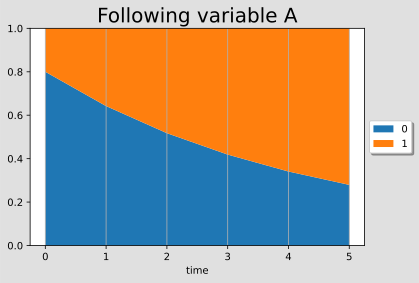

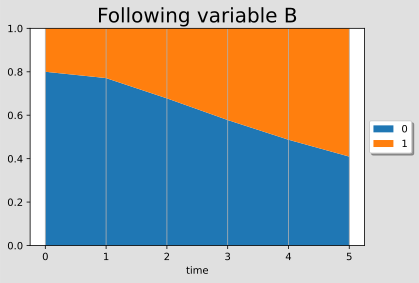

(gum::BayesNet<double>@0x127f2e600) BN{nodes: 22, arcs: 25, domainSize: 10^6.62266, dim: 104}

In [7]:
get_learner_dbn(get_parametered_twodbn(twodbn, {'learner_profile': 'average', 
                                                'link_a_to_b': 'strong'}), sim_evaluations[0])

hard
Evaluation #0 on KC A: fail
Evaluation #1 on KC A: success
Evaluation #2 on KC A: success
Evaluation #3 on KC A: success
Evaluation #4 on KC A: fail


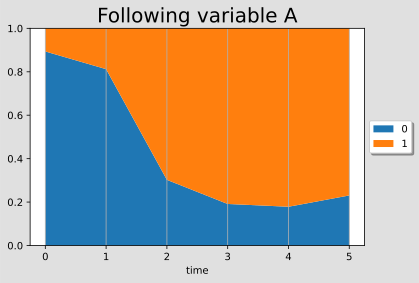

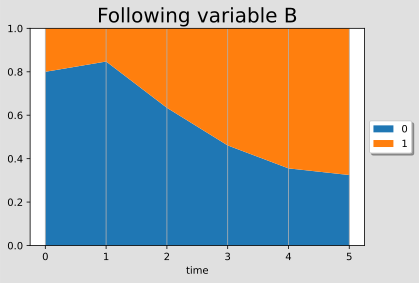

(gum::BayesNet<double>@0x127f8e600) BN{nodes: 22, arcs: 25, domainSize: 10^6.62266, dim: 104}

In [8]:
get_learner_dbn_w_evidences(get_parametered_twodbn(twodbn, {'learner_profile': 'average', 'link_a_to_b': 'strong'}), 
                            sim_evaluations[0], 
                            'hard')

soft
Evaluation #0 on KC A: fail
Evaluation #1 on KC A: success
Evaluation #2 on KC A: success
Evaluation #3 on KC A: success
Evaluation #4 on KC A: fail


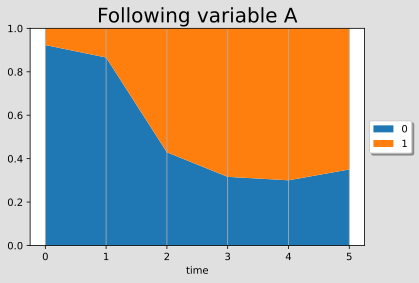

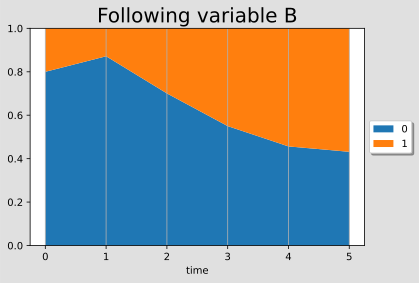

(gum::BayesNet<double>@0x156b1c400) BN{nodes: 22, arcs: 25, domainSize: 10^6.62266, dim: 104}

In [9]:
get_learner_dbn_w_evidences(get_parametered_twodbn(twodbn, {'learner_profile': 'average', 'link_a_to_b': 'strong'}), 
                            sim_evaluations[0], 
                            'soft')

In [10]:
def get_learner_last_state_estimate_w_partial_evidences(twodbn, learner_evals, evidence_type):
    slip=.1
    guess=.25
    evidences = {}
    for i in range(len(learner_evals)):
        # declaring hard evidences 
        if evidence_type == 'hard':
            evidences[f"eval{learner_evals[i][0].name}{i+1}"] = int(learner_evals[i][1]) 
        elif evidence_type == 'soft':
            evidences[f"{learner_evals[i][0].name}{i+1}"] = [guess, 1-guess] if learner_evals[i][1] else [1-slip, slip]
        else:
            return Exception("Evidence type not matched")
    
    dbn = gdyn.unroll2TBN(twodbn,len(learner_evals)+1)
    #gdyn.plotFollow(["A","B"],twodbn,T=len(learner_evals)+1,evs=evidences)
    ie=gum.LazyPropagation(dbn)
    exp_vals, pred_vals = [], []
    ie.setEvidence(evidences)
    ie.makeInference()
    for i in range(len(learner_evals)):
        exp_vals.append(int(learner_evals[i][1]))
        pred_vals.append(ie.posterior(dbn.idFromName(f"eval{learner_evals[i][0].name}{i+1}"))[1])
    return pred_vals, exp_vals



In [11]:
import random
import itertools
import numpy as np
from sklearn.metrics import roc_auc_score
possible_stereotypes = {'learner_profile': ['fast', 'average', 'slow'],
                        'link_a_to_b': ['strong', 'weak', 'not_existing']}


def compute_likelihood(predicted, expected):
    score=1
    for i in range(len(predicted)):
        if expected[i] == 1:
            score = score * predicted[i]
        else:
            score = score * (1-predicted[i])
    return -np.log(score)
    
    
to_be_tested = list(itertools.product(*[possible_stereotypes[key] for key in possible_stereotypes.keys()]))
score  = 1e8
epsilon = 0.1
selected_stereotype = {}
for el in to_be_tested:
    current_score = 0
    current_stereotype = {list(possible_stereotypes.keys())[i]: list(el)[i] for i in range(len(el))}
    print(current_stereotype)
    pred_vals, exp_vals = [], []
    for i in range(len(sim_evaluations)):
        if sim_evaluations[i]:
            parametered_twodbn = get_parametered_twodbn(twodbn, current_stereotype)
            pred_vals, exp_vals = get_learner_last_state_estimate_w_partial_evidences(parametered_twodbn, 
                                                                     sim_evaluations[i], 
                                                                     'soft') 
            current_score += compute_likelihood(pred_vals, exp_vals)
    print(current_score)
    if current_score < score:
        selected_stereotype = current_stereotype
        score = current_score


{'learner_profile': 'fast', 'link_a_to_b': 'strong'}
7068.910574606994
{'learner_profile': 'fast', 'link_a_to_b': 'weak'}
7231.586500371159
{'learner_profile': 'fast', 'link_a_to_b': 'not_existing'}
7424.9204833712665
{'learner_profile': 'average', 'link_a_to_b': 'strong'}
7477.049994270689
{'learner_profile': 'average', 'link_a_to_b': 'weak'}
7506.042422820501
{'learner_profile': 'average', 'link_a_to_b': 'not_existing'}
7714.061779310602
{'learner_profile': 'slow', 'link_a_to_b': 'strong'}
8100.18722262352
{'learner_profile': 'slow', 'link_a_to_b': 'weak'}
8007.194369123632
{'learner_profile': 'slow', 'link_a_to_b': 'not_existing'}
8210.11805384056
